# Previsão de churn (abandono) em telecom

### Referências:
- https://github.com/RomeroBarata/IF702-redes-neurais

### Grupo 8:
- Erbert Gadelha (ebgr)
- João Pedro (jpba)
- Vinicius Barbosa (vrb)
- Almir Alves (aasc)
- Felipe Mateus (fmfb)

# Preparação e importação da base de dados

In [ ]:
!pip install tabpfn optuna
!pip uninstall -y tensorflow keras
!pip install tensorflow==2.19.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.7/160.7 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 32.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 130.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 100.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from tabpfn import TabPFNClassifier
import optuna
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import kagglehub
import numpy as np
import numpy.typing as npt
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from scipy.stats import ks_2samp
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, recall_score, precision_score, f1_score, mean_squared_error

tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
print("Versão do TensorFlow:", tf.__version__)
print("GPU disponível:", tf.config.list_physical_devices('GPU'))

Versão do TensorFlow: 2.19.0
GPU disponível: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
#@title Download data and create DataFrame
churn_data_path = kagglehub.dataset_download("kapturovalexander/customers-churned-in-telecom-services")
print("Path to dataset files:", churn_data_path)

churn_df = pd.read_csv(churn_data_path + "/customer_churn_telecom_services.csv")
print(f"Data shape {churn_df.shape}")
churn_df.head()

Path to dataset files: /kaggle/input/customers-churned-in-telecom-services
Data shape (7043, 20)


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


# Exploração dos dados

### Descrição das colunas:

| Column Name | Description |
|-------------|-------------|
| gender | Customer's gender (Male/Female) |
| SeniorCitizen |	Indicates if the customer is a senior citizen (1 = Yes, 0 = No) |
| Partner | Whether the customer has a partner (Yes/No) |
| Dependents | Whether the customer has dependents (Yes/No) |
|tenure |	Number of months the customer has stayed with the company |
|PhoneService |	Whether the customer has a phone service (Yes/No) |
|MultipleLines | Whether the customer has multiple phone lines (No, Yes, No phone service) |
|InternetService | Type of internet service (DSL, Fiber optic, No) |
|OnlineSecurity |	Whether the customer has online security (Yes, No, No internet service) |
|OnlineBackup |	Whether the customer has online backup (Yes, No, No internet service) |
|DeviceProtection |	Whether the customer has device protection (Yes, No, No internet service) |
|TechSupport | Whether the customer has tech support (Yes, No, No internet service) |
|StreamingTV | Whether the customer has streaming TV (Yes, No, No internet service) |
|StreamingMovies |	Whether the customer has streaming movies (Yes, No, No internet service) |
|Contract |	Type of contract (Month-to-month, One year, Two year) |
|PaperlessBilling |	Whether the customer has paperless billing (Yes/No) |
|PaymentMethod | Payment method used (Electronic check, Mailed check, Bank transfer, Credit card) |
|MonthlyCharges |	Monthly charges the customer pays |
|TotalCharges |	Total amount charged to the customer |
|Churn |	Whether the customer has churned (Yes/No) |

## Verificando valores nulos

In [ ]:
#@title Verificando o dataset
churn_df.info()
nulls = churn_df['TotalCharges'].isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


A colunas `TotalCharges` possui 11 valores nulos, portanto essas amostras serão removidas.

In [ ]:
#@title Removendo valores nulos
print(f"Data shape (before cleaning) {churn_df.shape}")
churn_df = churn_df.dropna()
print(f"Data shape (after cleaning) {churn_df.shape}")

Data shape (before cleaning) (7043, 20)
Data shape (after cleaning) (7032, 20)


## Verificando outliers

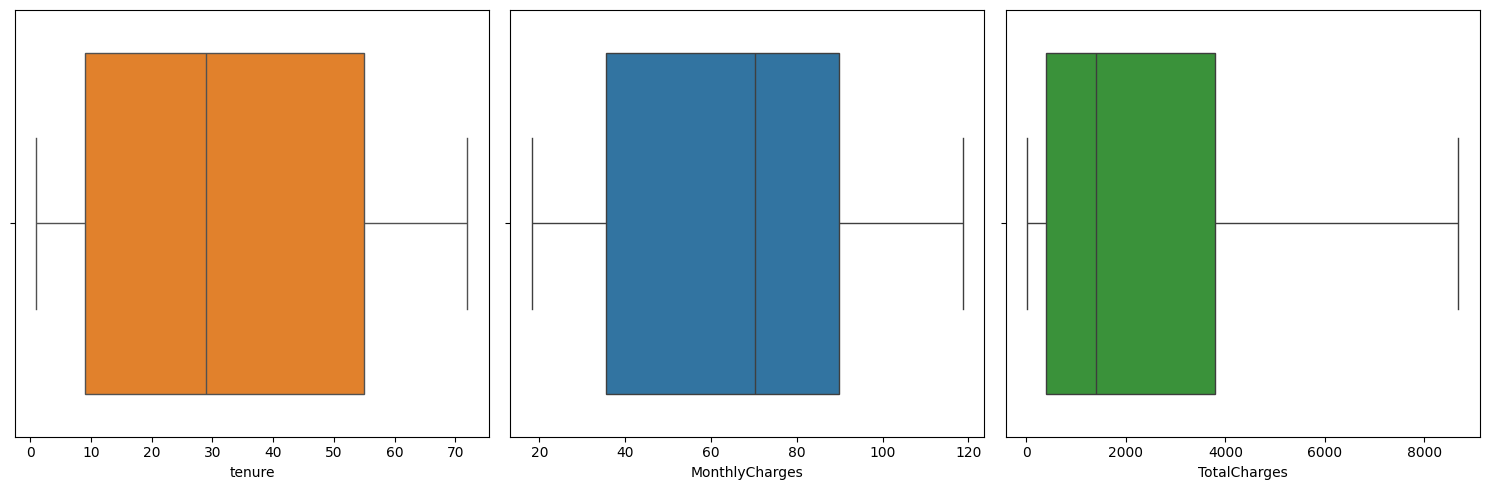

In [ ]:
#@title Verificando a existência de outliers

numerical_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
colors = ['tab:orange', 'tab:blue', 'tab:green']
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, feature in enumerate(numerical_features):
  sns.boxplot(churn_df, x=feature, ax=axes[i], color=colors[i])
plt.tight_layout()

## Analisando distribuições

### Features Contínuas

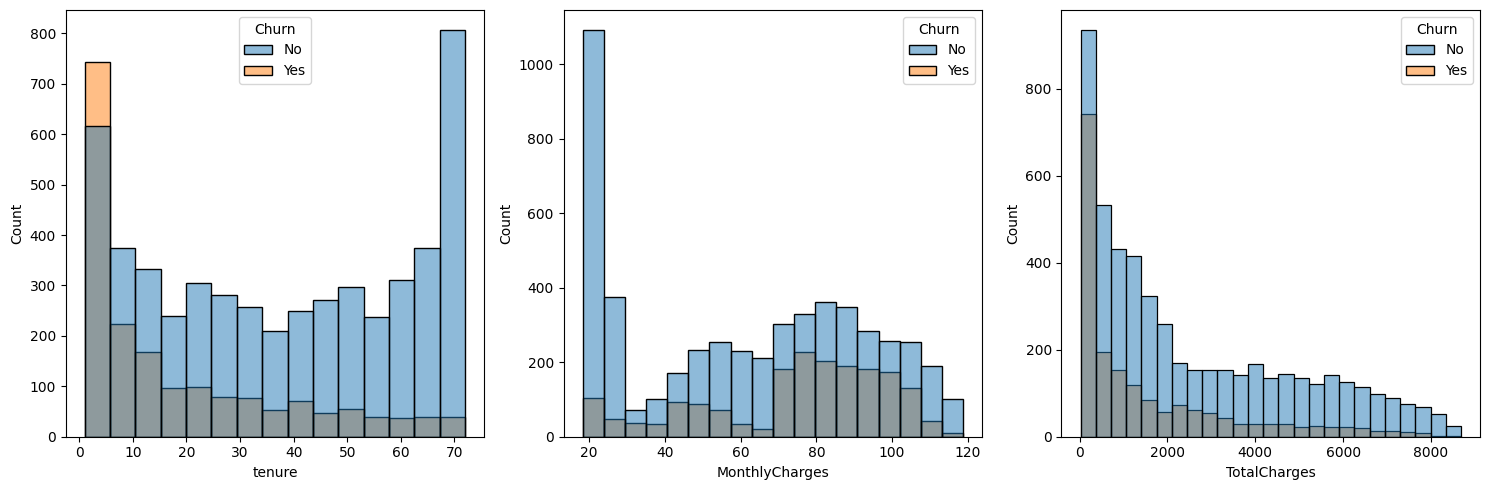

In [ ]:
#@title Histograma por abandono

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, feature in enumerate(numerical_features):
  sns.histplot(churn_df, x=feature, ax=axes[i], hue='Churn')
plt.tight_layout()
plt.show()

A partir das distribuições podemos deduzir os seguintes pontos:
*   Clientes jovens tendem a abandonar mais, enquanto pessoas com mais idade tendem a continuar sendo clientes
*   Cobranças mensais muito baixas contribuem para uma alta taxa de fidelidade, mas valores mais altos não apresentam uma influência notável



# Preparação dos dados

In [ ]:
#@title Convertendo tipos categóricos

cat_df = churn_df.select_dtypes(include=['object', 'category'])
for col in cat_df.columns:
  churn_df[col] = churn_df[col].astype('category')
  churn_df[col] = churn_df[col].cat.codes

  if col == 'Churn':
    continue

  # one hot encode if more than 2 alternatives
  if len(churn_df[col].unique()) > 2:
    churn_df = pd.concat([churn_df, pd.get_dummies(churn_df[col], prefix=col)], axis=1)
    churn_df = churn_df.drop(columns=[col])

churn_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 41 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              7032 non-null   int8   
 1   SeniorCitizen       7032 non-null   int64  
 2   Partner             7032 non-null   int8   
 3   Dependents          7032 non-null   int8   
 4   tenure              7032 non-null   int64  
 5   PhoneService        7032 non-null   int8   
 6   PaperlessBilling    7032 non-null   int8   
 7   MonthlyCharges      7032 non-null   float64
 8   TotalCharges        7032 non-null   float64
 9   Churn               7032 non-null   int8   
 10  MultipleLines_0     7032 non-null   bool   
 11  MultipleLines_1     7032 non-null   bool   
 12  MultipleLines_2     7032 non-null   bool   
 13  InternetService_0   7032 non-null   bool   
 14  InternetService_1   7032 non-null   bool   
 15  InternetService_2   7032 non-null   bool   
 16  OnlineSecur

In [ ]:
#@title Divisão estratificada Treino / Validação / Teste (50% / 25% / 25%)
X = churn_df.drop(columns=['Churn'])
y = churn_df['Churn']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.5, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Train shape {X_train.shape}")
print(f"Validation shape {X_val.shape}")
print(f"Test shape {X_test.shape}")

Train shape (3516, 40)
Validation shape (1758, 40)
Test shape (1758, 40)


In [ ]:
#@title Normalização das features numéricas

mean_train = X_train.mean()
std_train = X_train.std()

X_train_n = X_train.copy(deep=True)
X_val_n = X_val.copy(deep=True)
X_test_n = X_test.copy(deep=True)

for col in numerical_features:
  X_train_n[col] = (X_train[col] - mean_train[col]) / std_train[col]
  X_val_n[col] = (X_val[col] - mean_train[col]) / std_train[col]
  X_test_n[col] = (X_test[col] - mean_train[col]) / std_train[col]

print("===========================================================================")
print("Distribuições do conjunto de treino")
print("===========================================================================")
print(X_train.describe())
print("===========================================================================")
print("Distribuições (normalizadas) do conjunto de treino")
print("===========================================================================")
print(X_train_n.describe())

Distribuições do conjunto de treino
            gender  SeniorCitizen      Partner   Dependents       tenure  \
count  3516.000000    3516.000000  3516.000000  3516.000000  3516.000000   
mean      0.503982       0.165529     0.483788     0.300910    32.577361   
std       0.500055       0.371710     0.499808     0.458719    24.400907   
min       0.000000       0.000000     0.000000     0.000000     1.000000   
25%       0.000000       0.000000     0.000000     0.000000     9.000000   
50%       1.000000       0.000000     0.000000     0.000000    29.000000   
75%       1.000000       0.000000     1.000000     1.000000    55.000000   
max       1.000000       1.000000     1.000000     1.000000    72.000000   

       PhoneService  PaperlessBilling  MonthlyCharges  TotalCharges  
count   3516.000000       3516.000000     3516.000000   3516.000000  
mean       0.905575          0.593572       65.079238   2304.446217  
std        0.292461          0.491236       30.200006   2264.169199  

# Métodos auxiliares

In [ ]:
#@title Cálculo do Teste Kolmogorov-Smirnov

def calc_ks(y_true: npt.NDArray, y_pred: npt.NDArray):
  return ks_2samp(y_pred[y_true == 0], y_pred[y_true == 1])

In [ ]:
#@title Plot da Matriz de Confusão

def plot_conf_matrix(cm):
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.show()

In [ ]:
#@title Plot da curva ROC

def plot_roc(fpr, tpr, auc, label):
  plt.figure(figsize=(6, 6))
  plt.plot(fpr, tpr, label=f'{label} (AUC = {auc:.2f})')
  plt.plot([0, 1], [0, 1], '--', color='tab:orange')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend(loc="lower right")
  plt.show()

# Execução inicial com classificadores

In [ ]:
#@title Parâmetros gerais
epochs = 10000
patience = 20

## MLP

In [ ]:
#@title Definição do modelo
mlp_classifier = Sequential()
mlp_classifier.add(Input(shape=(X_train.shape[1],)))
mlp_classifier.add(Dense(10, activation='relu'))
mlp_classifier.add(Dense(1, activation='sigmoid'))
mlp_classifier.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
mlp_classifier.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 10)             │           410 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 421 (1.64 KB)

 Trainable params: 421 (1.64 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#@title Treinamento inicial
mlp_history = mlp_classifier.fit(X_train_n, y_train, epochs=epochs, validation_data=(X_val_n, y_val),
                                 callbacks=[EarlyStopping(patience=patience, monitor='val_loss')])

Epoch 1/10000


FailedPreconditionError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start

  File "/usr/local/lib/python3.11/dist-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.11/asyncio/base_events.py", line 608, in run_forever

  File "/usr/lib/python3.11/asyncio/base_events.py", line 1936, in _run_once

  File "/usr/lib/python3.11/asyncio/events.py", line 84, in _run

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 499, in process_one

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 730, in execute_request

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py", line 383, in do_execute

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/zmqshell.py", line 528, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "/tmp/ipython-input-3312322392.py", line 2, in <cell line: 0>

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 377, in fit

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 220, in function

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 133, in multi_step_on_iterator

DNN library initialization failed. Look at the errors above for more details.
	 [[{{node StatefulPartitionedCall}}]] [Op:__inference_multi_step_on_iterator_914]

### Avaliação inicial

In [ ]:
#@title Gerando predições
mlp_preds = mlp_classifier.predict(X_test_n)

In [ ]:
#@title Teste Kolmogorov-Smirnov
mlp_ks = calc_ks(y_test, mlp_preds)
print(f"Teste Kolmogorov-Smirnov: {mlp_ks.statistic[0]} (p-value: {mlp_ks.pvalue[0]})")

In [ ]:
#@title MSE
mlp_mse = mlp_classifier.evaluate(X_test_n, y_test, verbose=0)
print(f"MSE: {mlp_mse}")

In [ ]:
#@title Matriz de confusão
mlp_cm = confusion_matrix(y_test, np.round(mlp_preds))
plot_conf_matrix(mlp_cm)

In [ ]:
#@title AUC-ROC
mlp_auc = roc_auc_score(y_test, mlp_preds)
print(f"AUC-ROC: {mlp_auc}")
mlp_fpr, mlp_tpr, _ = roc_curve(y_test, mlp_preds)
plot_roc(mlp_fpr, mlp_tpr, mlp_auc, 'MLP')

In [ ]:
#@title Recall, precision e f-score
mlp_recall = recall_score(y_test, np.round(mlp_preds))
mlp_precision = precision_score(y_test, np.round(mlp_preds))
mlp_f1 = f1_score(y_test, np.round(mlp_preds))
print(f"Recall: {mlp_recall}")
print(f"Precision: {mlp_precision}")
print(f"F1-score: {mlp_f1}")

## Random Forest

In [ ]:
#@title Definição do modelo
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier

RandomForestClassifier(random_state=42)

In [ ]:
#@title Treinamento inicial
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

### Avaliação inicial

In [ ]:
#@title Gerando predições
rf_preds = rf_classifier.predict(X_test)
print(f"Predições: {rf_preds.shape}")

Predições: (1758,)


In [ ]:
#@title Teste Kolmogorov-Smirnov
rf_ks = calc_ks(y_test, rf_preds)
print(f"Teste Kolmogorov-Smirnov: {rf_ks.statistic} (p-value: {rf_ks.pvalue})")

Teste Kolmogorov-Smirnov: 0.3941767830989373 (p-value: 3.3656066161959896e-48)


In [ ]:
#@title MSE
rf_mse = mean_squared_error(y_test, rf_preds)
print(f"MSE: {rf_mse}")

MSE: 0.21103526734926054


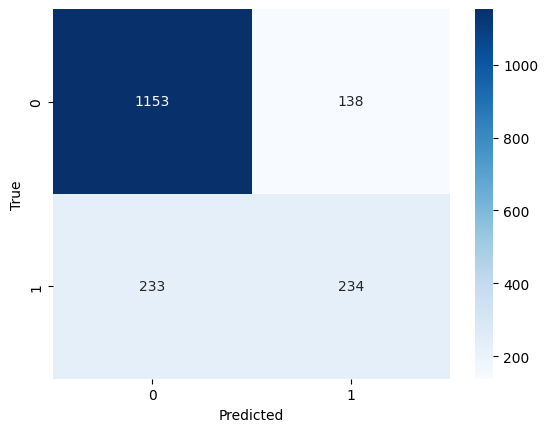

In [ ]:
#@title Matriz de confusão
rf_cm = confusion_matrix(y_test, rf_preds)
plot_conf_matrix(rf_cm)

AUC-ROC: 0.6970883915494687


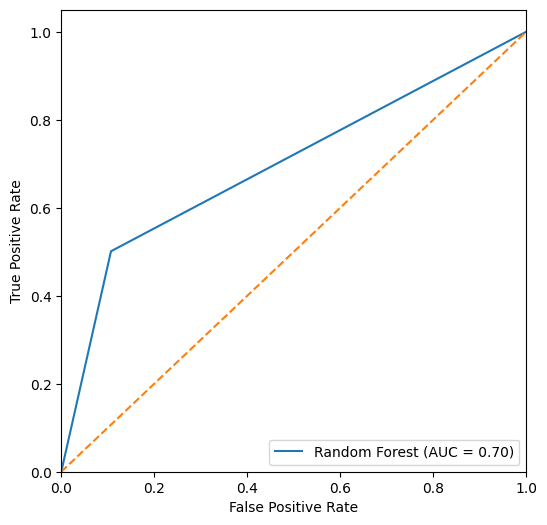

In [ ]:
#@title AUC-ROC
rf_auc = roc_auc_score(y_test, rf_preds)
print(f"AUC-ROC: {rf_auc}")
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_preds)
plot_roc(rf_fpr, rf_tpr, rf_auc, 'Random Forest')

In [ ]:
#@title Recall, precision e f-score
rf_recall = recall_score(y_test, rf_preds)
rf_precision = precision_score(y_test, rf_preds)
rf_f1 = f1_score(y_test, rf_preds)
print(f"Recall: {rf_recall}")
print(f"Precision: {rf_precision}")
print(f"F1-score: {rf_f1}")

Recall: 0.5010706638115632
Precision: 0.6290322580645161
F1-score: 0.5578069129916567


## TabPFN2 Transformer

In [ ]:
tabpfn = TabPFNClassifier(
    n_estimators=15,
    softmax_temperature=1,
    balance_probabilities=True,
    random_state=42,
)
tabpfn

TabPFNClassifier(balance_probabilities=True, n_estimators=15, random_state=42,
                 softmax_temperature=1)

In [ ]:
#@title Treinamento inicial
tabpfn.fit(X_train, y_train)

tabpfn-v2-classifier-finetuned-zk73skhh.(…):   0%|          | 0.00/29.0M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/37.0 [00:00<?, ?B/s]

TabPFNClassifier(balance_probabilities=True, n_estimators=15, random_state=42,
                 softmax_temperature=1)

In [ ]:
#@title Gerando predições
tabpfn_preds = tabpfn.predict(X_test)
print(f"Predições: {tabpfn_preds.shape}")

Predições: (1758,)


### Avaliação inicial

In [ ]:
#@title Teste Kolmogorov-Smirnov
tabpfn_ks = calc_ks(y_test, tabpfn_preds)
print(f"Teste Kolmogorov-Smirnov: {tabpfn_ks.statistic} (p-value: {tabpfn_ks.pvalue})")

Teste Kolmogorov-Smirnov: 0.5521639683063608 (p-value: 4.0765762122129324e-97)


In [ ]:
#@title (MSE ou Entropia Cruzada)
tabpfn_mse = mean_squared_error(y_test, tabpfn_preds)
print(f"MSE: {tabpfn_mse}")

MSE: 0.24857792946530147


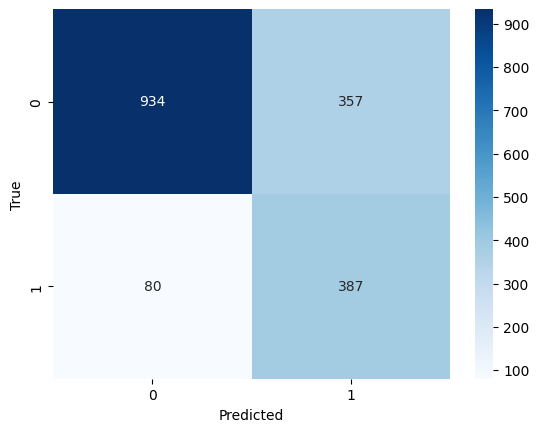

In [ ]:
#@title Matriz de confusão
tabpfn_cm = confusion_matrix(y_test, tabpfn_preds)
plot_conf_matrix(tabpfn_cm)

AUC-ROC: 0.7760819841531804


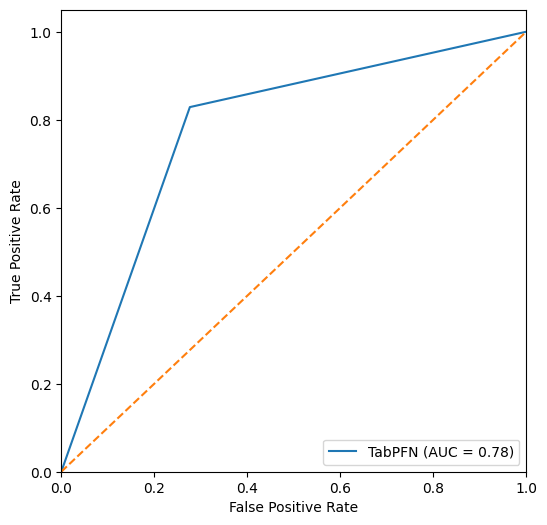

In [ ]:
#@title AUC-ROC
tabpfn_auc = roc_auc_score(y_test, tabpfn_preds)
print(f"AUC-ROC: {tabpfn_auc}")
tabpfn_fpr, tabpfn_tpr, _ = roc_curve(y_test, tabpfn_preds)
plot_roc(tabpfn_fpr, tabpfn_tpr, tabpfn_auc, 'TabPFN')

In [ ]:
#@title Recall, precision e f-score
tabpfn_recall = recall_score(y_test, tabpfn_preds)
tabpfn_precision = precision_score(y_test, tabpfn_preds)
tabpfn_f1 = f1_score(y_test, tabpfn_preds)
print(f"Recall: {tabpfn_recall}")
print(f"Precision: {tabpfn_precision}")
print(f"F1-score: {tabpfn_f1}")

Recall: 0.828693790149893
Precision: 0.5201612903225806
F1-score: 0.639141205615194


# Otimizando classificadores iniciais

## MLP

## Random Forest

# Executando mais classificadores

## STab

In [ ]:
#@title Treinamento inicial

### Avaliação inicial

In [ ]:
#@title Teste Kolmogorov-Smirnov

In [ ]:
#@title (MSE ou Entropia Cruzada)

In [ ]:
#@title Matriz de confusão

In [ ]:
#@title AUC-ROC

In [ ]:
#@title Recall, precision e f-score

## TabPFN2 Transformer

In [ ]:
def objective(trial):
    tabpfn = TabPFNClassifier(
        n_estimators=trial.suggest_int("n_estimators", 5, 60),
        softmax_temperature=trial.suggest_float("softmax_temperature", 0.3, 3.0, step=0.1),
        balance_probabilities=trial.suggest_categorical("balance_probabilities", [True, False]),
        random_state=42
    )

    tabpfn.fit(X_train, y_train)
    y_pred_proba = tabpfn.predict_proba(X_val)[:, 1]

    ks_value, _ = calc_ks(y_val, y_pred_proba)
    print(f"Trial {trial.number} | KS: {ks_value:.4f}")

    return ks_value

In [ ]:
#@title Treinamento inicial
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print("\nMelhores parâmetros encontrados:", study.best_params)
print("Melhor KS encontrado:", study.best_value)

[I 2025-08-11 03:10:25,262] A new study created in memory with name: no-name-972feccb-8c5b-4565-bc95-da8a79e74bf5
[I 2025-08-11 03:11:19,015] Trial 0 finished with value: 0.5352157997137156 and parameters: {'n_estimators': 55, 'softmax_temperature': 2.4, 'balance_probabilities': True}. Best is trial 0 with value: 0.5352157997137156.


Trial 0 | KS: 0.5352


[I 2025-08-11 03:11:51,471] Trial 1 finished with value: 0.5358079406598474 and parameters: {'n_estimators': 34, 'softmax_temperature': 1.4000000000000001, 'balance_probabilities': False}. Best is trial 1 with value: 0.5358079406598474.


Trial 1 | KS: 0.5358


[I 2025-08-11 03:12:28,089] Trial 2 finished with value: 0.5315286027298195 and parameters: {'n_estimators': 37, 'softmax_temperature': 2.6, 'balance_probabilities': False}. Best is trial 1 with value: 0.5358079406598474.


Trial 2 | KS: 0.5315


[I 2025-08-11 03:13:23,637] Trial 3 finished with value: 0.5328472359291886 and parameters: {'n_estimators': 56, 'softmax_temperature': 0.5, 'balance_probabilities': False}. Best is trial 1 with value: 0.5358079406598474.


Trial 3 | KS: 0.5328


[I 2025-08-11 03:14:09,432] Trial 4 finished with value: 0.5358112579760722 and parameters: {'n_estimators': 47, 'softmax_temperature': 2.2, 'balance_probabilities': False}. Best is trial 4 with value: 0.5358112579760722.


Trial 4 | KS: 0.5358


[I 2025-08-11 03:14:38,649] Trial 5 finished with value: 0.5317110551221851 and parameters: {'n_estimators': 30, 'softmax_temperature': 2.6, 'balance_probabilities': True}. Best is trial 4 with value: 0.5358112579760722.


Trial 5 | KS: 0.5317


[I 2025-08-11 03:14:54,455] Trial 6 finished with value: 0.5314805016445595 and parameters: {'n_estimators': 16, 'softmax_temperature': 2.0, 'balance_probabilities': False}. Best is trial 4 with value: 0.5358112579760722.


Trial 6 | KS: 0.5315


[I 2025-08-11 03:15:16,017] Trial 7 finished with value: 0.5408204054755622 and parameters: {'n_estimators': 22, 'softmax_temperature': 2.3, 'balance_probabilities': False}. Best is trial 7 with value: 0.5408204054755622.


Trial 7 | KS: 0.5408


[I 2025-08-11 03:16:03,028] Trial 8 finished with value: 0.5336699303529459 and parameters: {'n_estimators': 48, 'softmax_temperature': 1.5000000000000002, 'balance_probabilities': False}. Best is trial 7 with value: 0.5408204054755622.


Trial 8 | KS: 0.5337


[I 2025-08-11 03:16:44,825] Trial 9 finished with value: 0.5369507560993005 and parameters: {'n_estimators': 43, 'softmax_temperature': 2.0, 'balance_probabilities': False}. Best is trial 7 with value: 0.5408204054755622.


Trial 9 | KS: 0.5370


[I 2025-08-11 03:16:50,798] Trial 10 finished with value: 0.5373123435678068 and parameters: {'n_estimators': 5, 'softmax_temperature': 3.0, 'balance_probabilities': True}. Best is trial 7 with value: 0.5408204054755622.


Trial 10 | KS: 0.5373


[I 2025-08-11 03:16:57,934] Trial 11 finished with value: 0.550618098945591 and parameters: {'n_estimators': 7, 'softmax_temperature': 2.9, 'balance_probabilities': True}. Best is trial 11 with value: 0.550618098945591.


Trial 11 | KS: 0.5506


[I 2025-08-11 03:17:17,202] Trial 12 finished with value: 0.5305682396827319 and parameters: {'n_estimators': 19, 'softmax_temperature': 3.0, 'balance_probabilities': True}. Best is trial 11 with value: 0.550618098945591.


Trial 12 | KS: 0.5306


[I 2025-08-11 03:17:24,347] Trial 13 finished with value: 0.550618098945591 and parameters: {'n_estimators': 7, 'softmax_temperature': 2.7, 'balance_probabilities': True}. Best is trial 11 with value: 0.550618098945591.


Trial 13 | KS: 0.5506


[I 2025-08-11 03:17:30,330] Trial 14 finished with value: 0.5310674957745685 and parameters: {'n_estimators': 6, 'softmax_temperature': 0.7, 'balance_probabilities': True}. Best is trial 11 with value: 0.550618098945591.


Trial 14 | KS: 0.5311


[I 2025-08-11 03:17:42,236] Trial 15 finished with value: 0.5302448013508112 and parameters: {'n_estimators': 12, 'softmax_temperature': 1.1, 'balance_probabilities': True}. Best is trial 11 with value: 0.550618098945591.


Trial 15 | KS: 0.5302


[I 2025-08-11 03:18:06,936] Trial 16 finished with value: 0.5323031960683168 and parameters: {'n_estimators': 25, 'softmax_temperature': 2.8, 'balance_probabilities': True}. Best is trial 11 with value: 0.550618098945591.


Trial 16 | KS: 0.5323


[I 2025-08-11 03:18:18,827] Trial 17 finished with value: 0.5295697274990587 and parameters: {'n_estimators': 12, 'softmax_temperature': 1.8, 'balance_probabilities': True}. Best is trial 11 with value: 0.550618098945591.


Trial 17 | KS: 0.5296


[I 2025-08-11 03:18:29,936] Trial 18 finished with value: 0.5322103112140216 and parameters: {'n_estimators': 11, 'softmax_temperature': 2.7, 'balance_probabilities': True}. Best is trial 11 with value: 0.550618098945591.


Trial 18 | KS: 0.5322


[I 2025-08-11 03:18:35,672] Trial 19 finished with value: 0.538086936906304 and parameters: {'n_estimators': 5, 'softmax_temperature': 1.1, 'balance_probabilities': True}. Best is trial 11 with value: 0.550618098945591.


Trial 19 | KS: 0.5381


[I 2025-08-11 03:19:02,337] Trial 20 finished with value: 0.5226912723068783 and parameters: {'n_estimators': 27, 'softmax_temperature': 2.4, 'balance_probabilities': True}. Best is trial 11 with value: 0.550618098945591.


Trial 20 | KS: 0.5227


[I 2025-08-11 03:19:15,802] Trial 21 finished with value: 0.5371746749444765 and parameters: {'n_estimators': 14, 'softmax_temperature': 2.3, 'balance_probabilities': False}. Best is trial 11 with value: 0.550618098945591.


Trial 21 | KS: 0.5372


[I 2025-08-11 03:19:36,561] Trial 22 finished with value: 0.5373604446530668 and parameters: {'n_estimators': 21, 'softmax_temperature': 2.8, 'balance_probabilities': True}. Best is trial 11 with value: 0.550618098945591.


Trial 22 | KS: 0.5374


[I 2025-08-11 03:19:57,742] Trial 23 finished with value: 0.5415949988140595 and parameters: {'n_estimators': 22, 'softmax_temperature': 3.0, 'balance_probabilities': False}. Best is trial 11 with value: 0.550618098945591.


Trial 23 | KS: 0.5416


[I 2025-08-11 03:20:07,069] Trial 24 finished with value: 0.5313909341064892 and parameters: {'n_estimators': 9, 'softmax_temperature': 3.0, 'balance_probabilities': True}. Best is trial 11 with value: 0.550618098945591.


Trial 24 | KS: 0.5314


[I 2025-08-11 03:20:23,958] Trial 25 finished with value: 0.5301618684451904 and parameters: {'n_estimators': 17, 'softmax_temperature': 2.6, 'balance_probabilities': True}. Best is trial 11 with value: 0.550618098945591.


Trial 25 | KS: 0.5302


[I 2025-08-11 03:20:33,238] Trial 26 finished with value: 0.5313909341064892 and parameters: {'n_estimators': 9, 'softmax_temperature': 2.9, 'balance_probabilities': False}. Best is trial 11 with value: 0.550618098945591.


Trial 26 | KS: 0.5314


[I 2025-08-11 03:20:58,379] Trial 27 finished with value: 0.5328953370144486 and parameters: {'n_estimators': 25, 'softmax_temperature': 2.5, 'balance_probabilities': True}. Best is trial 11 with value: 0.550618098945591.


Trial 27 | KS: 0.5329


[I 2025-08-11 03:21:14,740] Trial 28 finished with value: 0.5314805016445595 and parameters: {'n_estimators': 16, 'softmax_temperature': 2.1, 'balance_probabilities': False}. Best is trial 11 with value: 0.550618098945591.


Trial 28 | KS: 0.5315


[I 2025-08-11 03:21:53,131] Trial 29 finished with value: 0.5311636979450884 and parameters: {'n_estimators': 39, 'softmax_temperature': 1.8, 'balance_probabilities': True}. Best is trial 11 with value: 0.550618098945591.


Trial 29 | KS: 0.5312


[I 2025-08-11 03:22:51,058] Trial 30 finished with value: 0.5350366646375749 and parameters: {'n_estimators': 60, 'softmax_temperature': 2.8, 'balance_probabilities': True}. Best is trial 11 with value: 0.550618098945591.


Trial 30 | KS: 0.5350


[I 2025-08-11 03:23:12,025] Trial 31 finished with value: 0.5365858513145695 and parameters: {'n_estimators': 21, 'softmax_temperature': 2.4, 'balance_probabilities': False}. Best is trial 11 with value: 0.550618098945591.


Trial 31 | KS: 0.5366


[I 2025-08-11 03:23:43,621] Trial 32 finished with value: 0.5365858513145695 and parameters: {'n_estimators': 31, 'softmax_temperature': 2.7, 'balance_probabilities': False}. Best is trial 11 with value: 0.550618098945591.


Trial 32 | KS: 0.5366


[I 2025-08-11 03:24:04,774] Trial 33 finished with value: 0.5415949988140595 and parameters: {'n_estimators': 22, 'softmax_temperature': 2.4, 'balance_probabilities': False}. Best is trial 11 with value: 0.550618098945591.


Trial 33 | KS: 0.5416


[I 2025-08-11 03:24:38,956] Trial 34 finished with value: 0.5324856484606824 and parameters: {'n_estimators': 35, 'softmax_temperature': 2.5, 'balance_probabilities': False}. Best is trial 11 with value: 0.550618098945591.


Trial 34 | KS: 0.5325


[I 2025-08-11 03:24:47,160] Trial 35 finished with value: 0.5315733864988547 and parameters: {'n_estimators': 8, 'softmax_temperature': 2.9, 'balance_probabilities': False}. Best is trial 11 with value: 0.550618098945591.


Trial 35 | KS: 0.5316


[I 2025-08-11 03:25:15,735] Trial 36 finished with value: 0.5287022493062662 and parameters: {'n_estimators': 29, 'softmax_temperature': 2.7, 'balance_probabilities': False}. Best is trial 11 with value: 0.550618098945591.


Trial 36 | KS: 0.5287


[I 2025-08-11 03:25:39,258] Trial 37 finished with value: 0.5293872751066931 and parameters: {'n_estimators': 24, 'softmax_temperature': 2.6, 'balance_probabilities': False}. Best is trial 11 with value: 0.550618098945591.


Trial 37 | KS: 0.5294


[I 2025-08-11 03:25:57,435] Trial 38 finished with value: 0.5321207436759513 and parameters: {'n_estimators': 18, 'softmax_temperature': 2.2, 'balance_probabilities': False}. Best is trial 11 with value: 0.550618098945591.


Trial 38 | KS: 0.5321


[I 2025-08-11 03:26:30,675] Trial 39 finished with value: 0.5340796189067121 and parameters: {'n_estimators': 34, 'softmax_temperature': 3.0, 'balance_probabilities': False}. Best is trial 11 with value: 0.550618098945591.


Trial 39 | KS: 0.5341


[I 2025-08-11 03:26:43,573] Trial 40 finished with value: 0.5425072607758871 and parameters: {'n_estimators': 13, 'softmax_temperature': 2.5, 'balance_probabilities': False}. Best is trial 11 with value: 0.550618098945591.


Trial 40 | KS: 0.5425


[I 2025-08-11 03:26:57,297] Trial 41 finished with value: 0.5371746749444765 and parameters: {'n_estimators': 14, 'softmax_temperature': 2.8, 'balance_probabilities': False}. Best is trial 11 with value: 0.550618098945591.


Trial 41 | KS: 0.5372


[I 2025-08-11 03:27:05,248] Trial 42 finished with value: 0.5323479798373519 and parameters: {'n_estimators': 8, 'softmax_temperature': 2.5, 'balance_probabilities': False}. Best is trial 11 with value: 0.550618098945591.


Trial 42 | KS: 0.5323


[I 2025-08-11 03:27:20,139] Trial 43 finished with value: 0.5371746749444765 and parameters: {'n_estimators': 14, 'softmax_temperature': 2.3, 'balance_probabilities': False}. Best is trial 11 with value: 0.550618098945591.


Trial 43 | KS: 0.5372


[I 2025-08-11 03:27:38,961] Trial 44 finished with value: 0.5297936463442345 and parameters: {'n_estimators': 19, 'softmax_temperature': 0.3, 'balance_probabilities': False}. Best is trial 11 with value: 0.550618098945591.


Trial 44 | KS: 0.5298


[I 2025-08-11 03:27:50,219] Trial 45 finished with value: 0.5333945931062851 and parameters: {'n_estimators': 11, 'softmax_temperature': 1.9000000000000001, 'balance_probabilities': False}. Best is trial 11 with value: 0.550618098945591.


Trial 45 | KS: 0.5334


[I 2025-08-11 03:27:57,438] Trial 46 finished with value: 0.550618098945591 and parameters: {'n_estimators': 7, 'softmax_temperature': 2.9, 'balance_probabilities': False}. Best is trial 11 with value: 0.550618098945591.


Trial 46 | KS: 0.5506


[I 2025-08-11 03:28:04,687] Trial 47 finished with value: 0.550618098945591 and parameters: {'n_estimators': 7, 'softmax_temperature': 3.0, 'balance_probabilities': True}. Best is trial 11 with value: 0.550618098945591.


Trial 47 | KS: 0.5506


[I 2025-08-11 03:28:13,143] Trial 48 finished with value: 0.550618098945591 and parameters: {'n_estimators': 7, 'softmax_temperature': 2.9, 'balance_probabilities': True}. Best is trial 11 with value: 0.550618098945591.


Trial 48 | KS: 0.5506


[I 2025-08-11 03:28:19,214] Trial 49 finished with value: 0.52819635858198 and parameters: {'n_estimators': 6, 'softmax_temperature': 2.9, 'balance_probabilities': True}. Best is trial 11 with value: 0.550618098945591.


Trial 49 | KS: 0.5282

Melhores parâmetros encontrados: {'n_estimators': 7, 'softmax_temperature': 2.9, 'balance_probabilities': True}
Melhor KS encontrado: 0.550618098945591


In [ ]:
#@title Gerando predições
best_params = study.best_params
best_params["random_state"] = 42
best_model = TabPFNClassifier(**best_params)
best_model.fit(X_train, y_train)

y_pred_proba = best_model.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba >= 0.5).astype(int)

### Avaliação inicial

In [ ]:
#@title Teste Kolmogorov-Smirnov
ks_stat, ks_pvalue = calc_ks(y_test, y_pred_proba)
print("\nTeste Kolmogorov-Smirnov:", ks_stat, "(p-value:", ks_pvalue, ")")


Teste Kolmogorov-Smirnov: 0.5591353083528364 (p-value: 9.552334094467434e-100 )


In [ ]:
#@title (MSE ou Entropia Cruzada)
mse = mean_squared_error(y_test, y_pred_proba)
print("MSE:", mse)

MSE: 0.25918158888816833


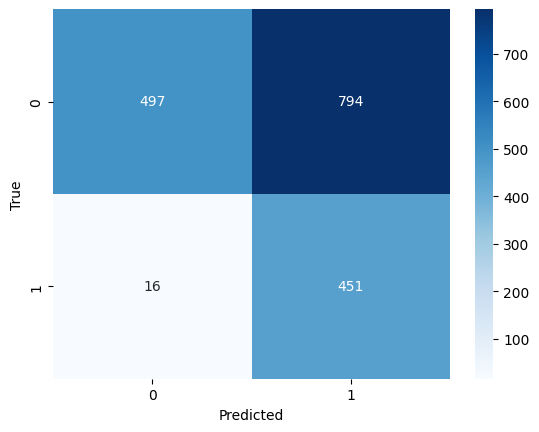

In [ ]:
#@title Matriz de confusão
cm = confusion_matrix(y_test, y_pred)
plot_conf_matrix(cm)

AUC-ROC: 0.8535612219002583


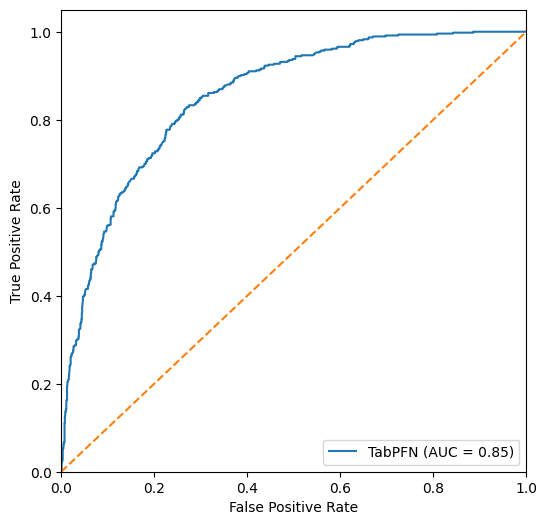

In [ ]:
#@title AUC-ROC
auc = roc_auc_score(y_test, y_pred_proba)
print("AUC-ROC:", auc)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plot_roc(fpr, tpr, auc, 'TabPFN')

In [ ]:
#@title Recall, precision e f1-score
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print("Recall:", recall)
print("Precision:", precision)
print("F1-score:", f1)

Recall: 0.9657387580299786
Precision: 0.36224899598393573
F1-score: 0.5268691588785047


## Gradient Boosting

### Primeira execução

In [ ]:
#@title Definição do modelo
gb_classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb_classifier

In [ ]:
#@title Treinamento inicial
gb_classifier.fit(X_train, y_train)

#### Avaliação inicial

In [ ]:
#@title Gerando predições
gb_preds = gb_classifier.predict(X_test)
print(f"Predições: {gb_preds.shape}")

In [ ]:
#@title Teste Kolmogorov-Smirnov
gb_ks = calc_ks(y_test, gb_preds)
print(f"Teste Kolmogorov-Smirnov: {gb_ks.statistic} (p-value: {gb_ks.pvalue})")

In [ ]:
#@title MSE
gb_mse = mean_squared_error(y_test, gb_preds)
print(f"MSE: {gb_mse}")

In [ ]:
#@title Matriz de confusão
gb_cm = confusion_matrix(y_test, gb_preds)
plot_conf_matrix(gb_cm)

In [ ]:
#@title AUC-ROC
gb_auc = roc_auc_score(y_test, gb_preds)
print(f"AUC-ROC: {gb_auc}")
gb_fpr, gb_tpr, _ = roc_curve(y_test, gb_preds)
plot_roc(gb_fpr, gb_tpr, gb_auc, 'Gradient Boosting')

In [ ]:
#@title Recall, precision e f-score
gb_recall = recall_score(y_test, gb_preds)
gb_precision = precision_score(y_test, gb_preds)
gb_f1 = f1_score(y_test, gb_preds)
print(f"Recall: {gb_recall}")
print(f"Precision: {gb_precision}")
print(f"F1-score: {gb_f1}")

# Avaliação final

## Comparação de métricas de todos os modelos